In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

from dib_profile import DibProfile
from models import n_gaussian

In [12]:
def load_profiles(target: str, ew_threshold = 0.0001):
    profiles_file = open(f'export/profiles/{target}_gaussians.csv', 'r')
    dib_profiles = []
    dib_centers = []
    dib_ews = []
    bad_fits = []

    for profile in profiles_file.readlines():
        # Skip comments
        if profile.startswith('#'):
            continue

        _, start, end, centers, widths, amplitudes, skews, rmse, r2, fwhm, ew = profile.split('\t')
        ew = float(ew.replace('\n', ''))

        start, end = float(start), float(end)
        centers = np.fromstring(centers.strip('[]'), sep=',')
        widths = np.fromstring(widths.strip('[]'), sep=',')
        amplitudes = np.fromstring(amplitudes.strip('[]'), sep=',')
        skews = np.fromstring(skews.strip('[]'), sep=',')

        if ew < ew_threshold:
            bad_fits.append(np.mean(centers).astype(int))
            continue

        dib_profiles.append(DibProfile(target, n_gaussian, np.column_stack((centers, widths, amplitudes, skews)).flatten(), start, end))
        dib_centers.append(np.mean(centers).astype(int))
        dib_ews.append(ew)

    print(f'{target} bad fits {len(bad_fits)}/{len(bad_fits) + len(dib_ews)}: {len(bad_fits) / (len(bad_fits) + len(dib_ews)) * 100:.1f}% | {np.array2string(np.array(bad_fits), separator=',')}')
    return np.array(dib_profiles, dtype=object), np.array(dib_centers), np.array(dib_ews)

In [ ]:
def synthetic_spectrum(wavelength, profiles):
    synth_spectrum = np.ones(wavelength.shape)

    for profile in profiles:
        profile_mask = (profile.start - 5 < wavelength) & (wavelength < profile.end + 5)
        pred = profile.predict(wavelength[profile_mask])

        if len(pred) > 1 and np.min(pred) < -1:
            continue

        synth_spectrum[profile_mask] += pred
    
    return synth_spectrum


In [25]:
targets = ['HD185859', 'HD147889', 'HD158926', 'HD170740']
wavelength = np.arange(4000, 10_000, 1e-2)
profiles_per_target = []
centers_per_target = []
ews_per_target = []

for target in targets:
    profiles, centers, ews = load_profiles(target)
    profiles_per_target.append(profiles)
    centers_per_target.append(centers)
    ews_per_target.append(ews)

synthetic_spectra = np.array([synthetic_spectrum(wavelength, profiles) for profiles in profiles_per_target])

HD185859 bad fits 10/494: 2.0% | [4682,4983,5800,6419,6778,7139,7360,7384,7568,8438]
HD147889 bad fits 2/421: 0.5% | [5169,7568]
HD158926 bad fits 6/342: 1.8% | [4968,5512,6698,6813,6979,7471]
HD170740 bad fits 2/383: 0.5% | [7471,7828]


In [33]:
def plot_synth_spec(synth_spectrum, target_name, subplot_size = 2000, filename = None):
    n_plots = np.ceil((wavelength[-1] - wavelength[0]) / subplot_size).astype(int)

    fig, axes = plt.subplots(n_plots, 1, figsize=(20, 3 * n_plots), sharey=True)

    for i, ax in enumerate(axes):
        start = i * subplot_size + wavelength[0]
        end = start + subplot_size
        range_mask = (start < wavelength) & (wavelength < end)

        ax.plot(wavelength[range_mask], synth_spectrum[range_mask])
        ax.set_ylabel('Normalized flux')
        ax.set_ylim(ymin=0)

        # Set label on last plot
        if i + 1 == n_plots:
            ax.set_xlabel('Wavelength [Å]')

    fig.suptitle(f'Synthetic spectrum of {target_name}')
    fig.tight_layout()

    if filename is not None:
        fig.savefig(f'export/{filename}')

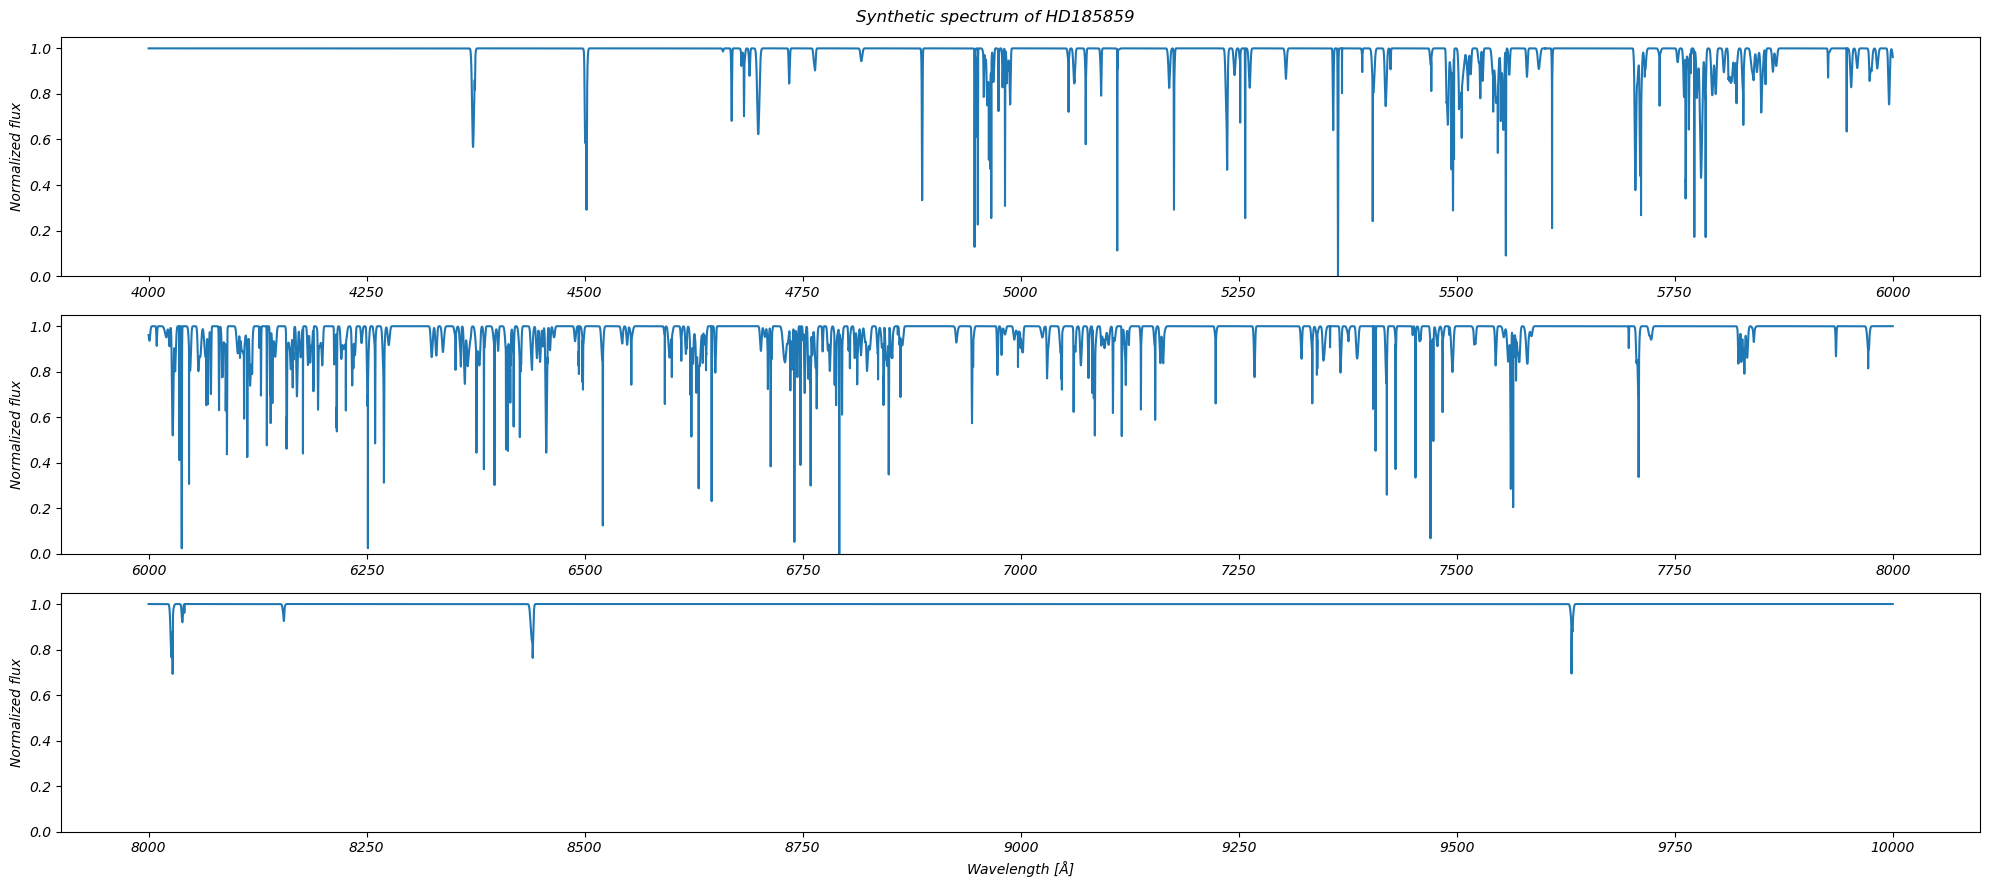

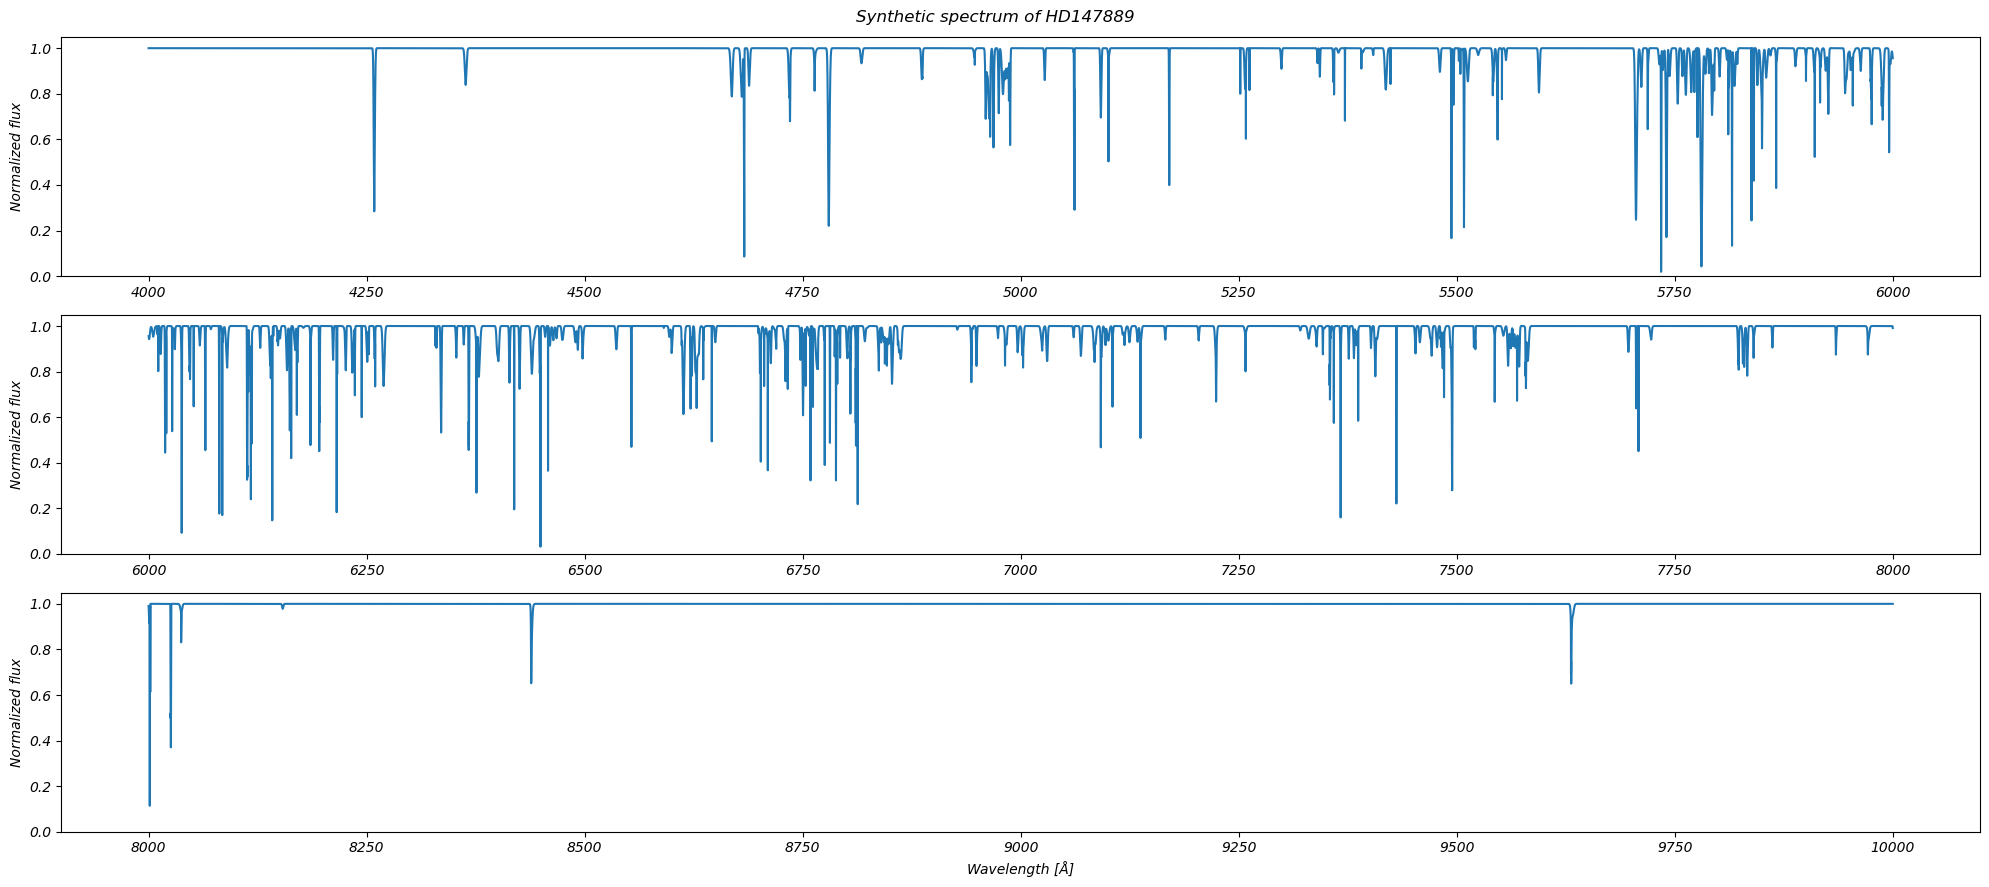

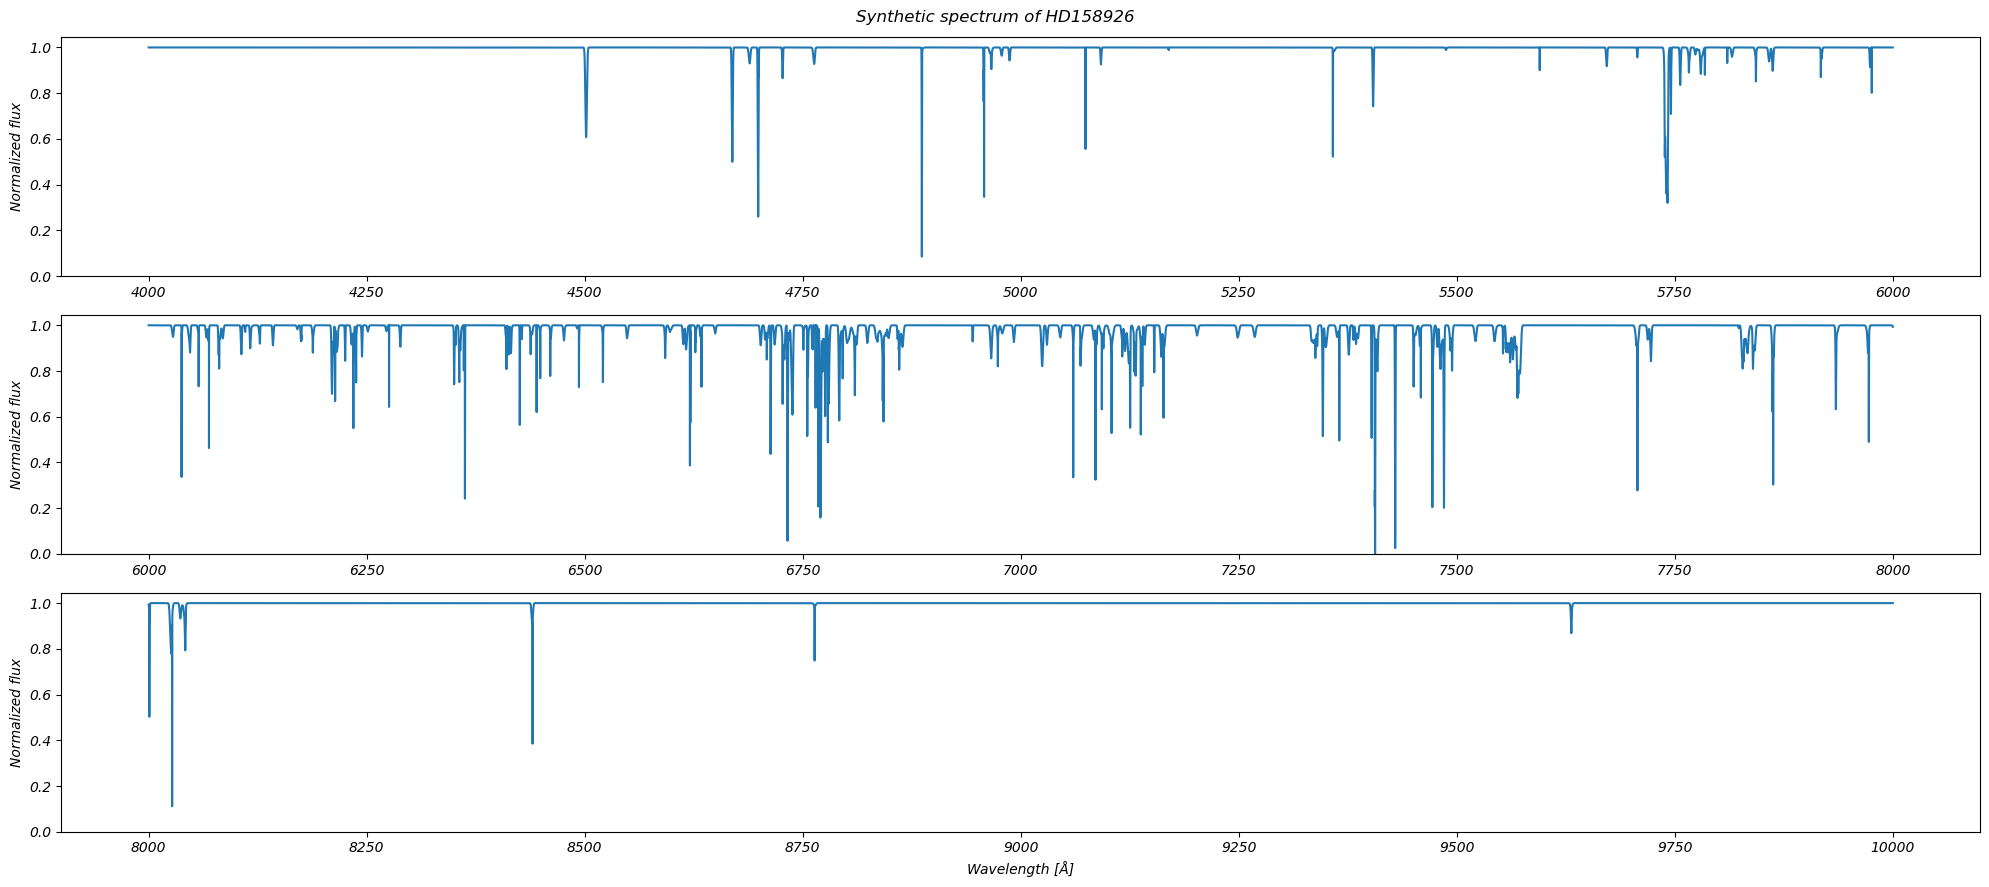

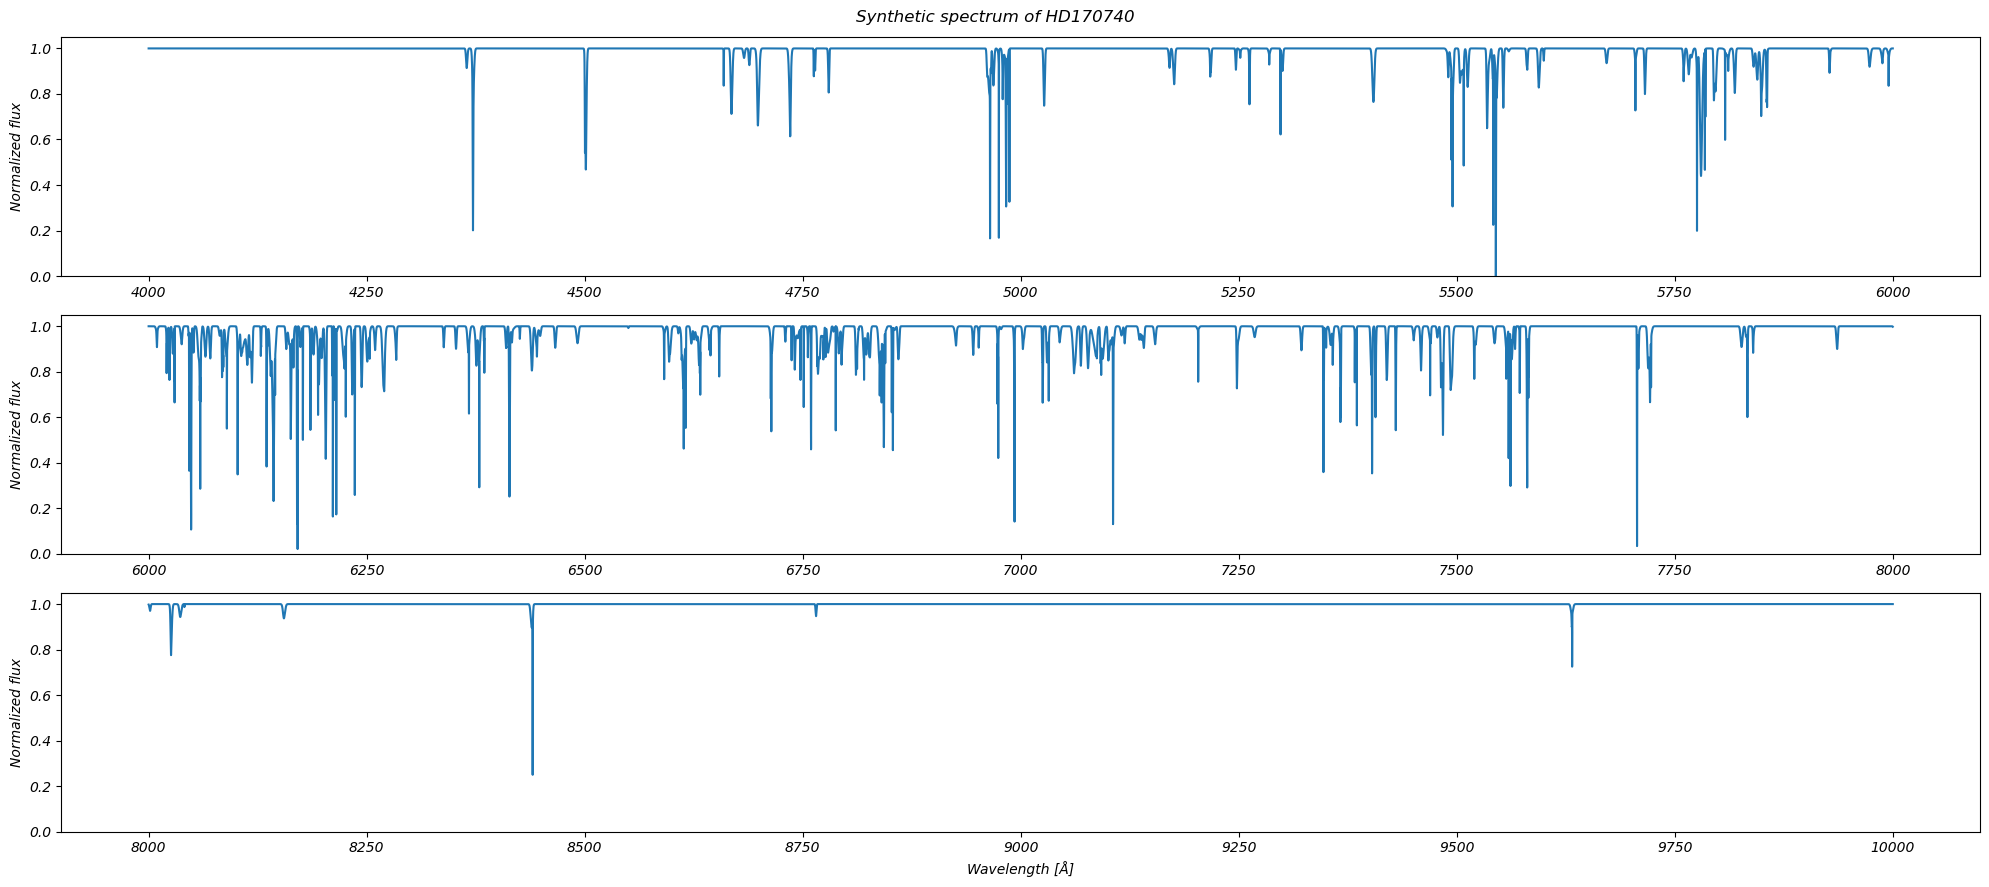

In [34]:
for synth_spec, target in zip(synthetic_spectra, targets):
    plot_synth_spec(synth_spec, target, filename=f'synth_spec_{target}.pdf')

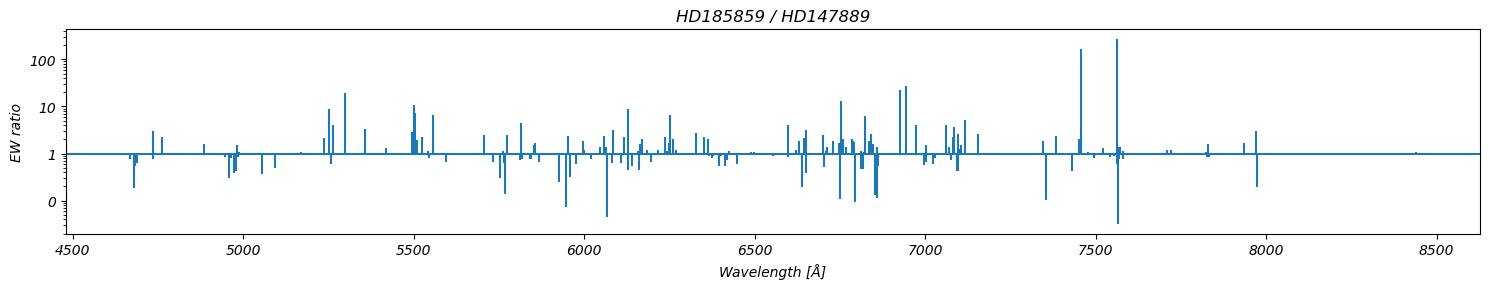

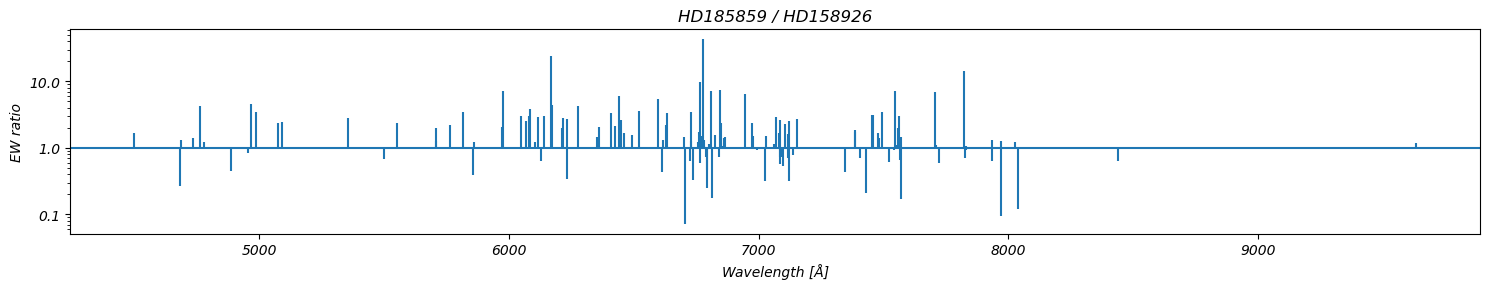

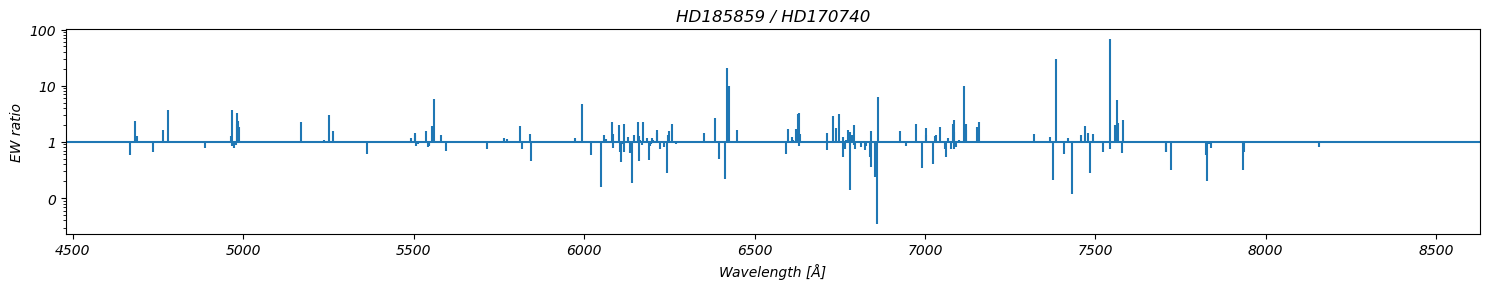

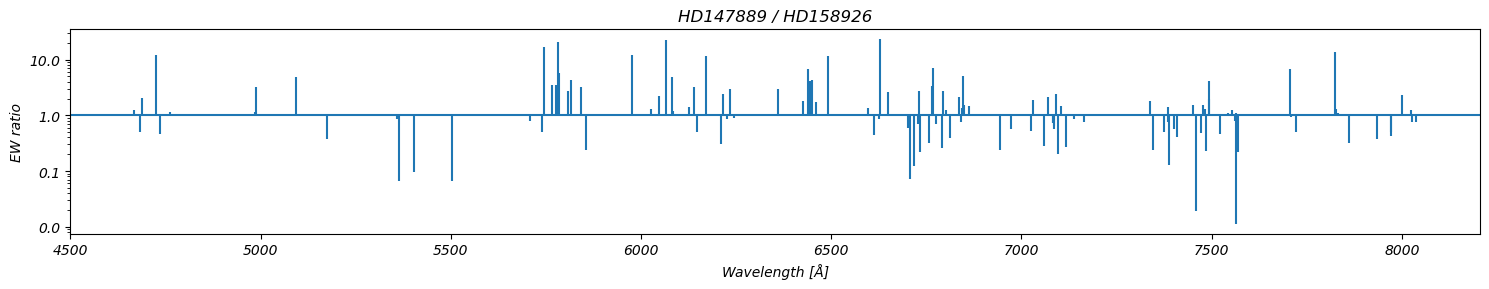

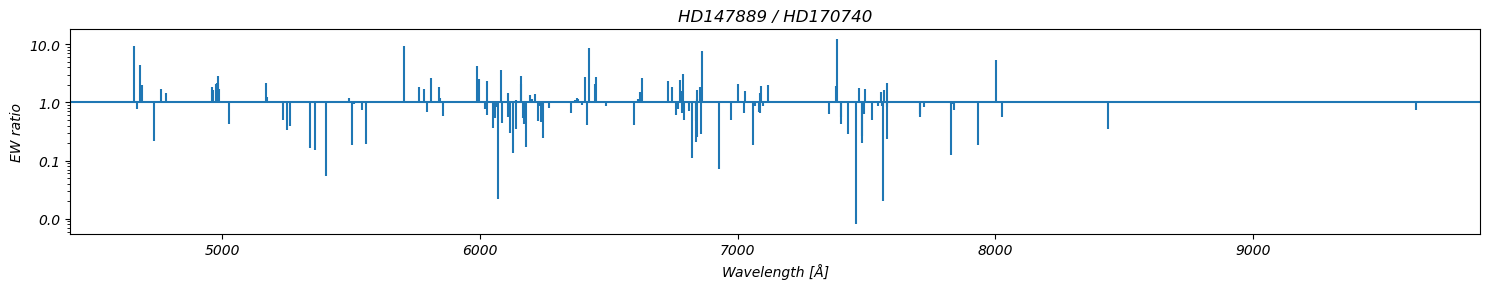

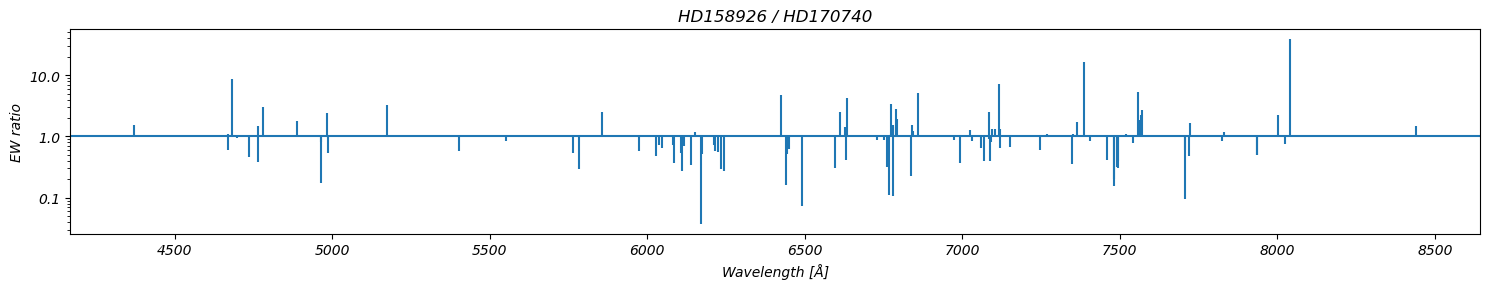

In [35]:
import itertools
from matplotlib.ticker import ScalarFormatter

for idx1, idx2 in itertools.combinations(range(len(synthetic_spectra)), 2):
    same_dib_centers, indices1, indices2 = np.intersect1d(centers_per_target[idx1], centers_per_target[idx2], return_indices=True)
    same_ews1 = ews_per_target[idx1][indices1]
    same_ews2 = ews_per_target[idx2][indices2]
    ew_ratio = same_ews1 / same_ews2

    fig, ax = plt.subplots(1, 1, figsize=(15, 3))

    ax.vlines(same_dib_centers, ymin=1, ymax=ew_ratio)

    ax.axhline(1)
    ax.set_title(f'{targets[idx1]} / {targets[idx2]}')
    ax.set_xlabel('Wavelength [Å]')
    ax.set_ylabel('EW ratio')
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.ticklabel_format(style='plain')
    fig.tight_layout()
    fig.savefig(f'export/{targets[idx1]}_{targets[idx2]}_ew_ratio.pdf')
        